In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np

#Autoencoders

In [2]:
train_ds = torchvision.datasets.MNIST("./",download=True,train=True,transform=torchvision.transforms.ToTensor())
test_ds = torchvision.datasets.MNIST("./",download=True,train=False,transform=torchvision.transforms.ToTensor())

train_dl = torch.utils.data.DataLoader(train_ds,batch_size=64)
test_dl = torch.utils.data.DataLoader(test_ds,batch_size=64)

In [3]:
def conv_block(inplanes,outplanes,kernel_size=3,stride=1,padding=1):
  return nn.Sequential(
      nn.Conv2d(inplanes,outplanes,kernel_size=kernel_size,stride=stride,padding=padding,bias=False),
      nn.BatchNorm2d(outplanes),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(2)
  )

def deconv_block(inplanes,outplanes,kernel_size=4,stride=2,padding=1):
  return nn.Sequential(
      nn.ConvTranspose2d(inplanes,outplanes,kernel_size=kernel_size,stride=stride,padding=padding,bias=False),
      nn.BatchNorm2d(outplanes),
      nn.ReLU(inplace=True),
  )

class Reshape(nn.Module):
  def __init__(self, new_shape):
    super().__init__()
    self.new_shape = new_shape
  def forward(self,x):
    return x.view(self.new_shape)
class AutoEncoderModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        conv_block(1,16),
        conv_block(16,32),
        conv_block(32,64),
        conv_block(64,128),
        nn.Flatten()
    )
    self.decoder = nn.Sequential(
        nn.Linear(128,7*7*32),
        Reshape((-1,32,7,7)),
        deconv_block(32,16),
        deconv_block(16,1),
    )
  def forward(self, x):
    return self.decoder(self.encoder(x))

In [4]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
model = AutoEncoderModel().to(dev)

In [6]:
def evaluate(model, loader, crit):
  model.eval()
  avg_loss = 0
  for x, _ in loader:
    x = x.to(dev)
    o = model(x)
    loss = crit(o,x)
    avg_loss += loss.item()
  avg_loss /= len(loader)  
  return avg_loss

def train_one_epoch(model, train_loader, crit, optim):
  model.train()
  avg_loss = 0
  for x, _ in train_loader:
    optim.zero_grad()
    x = x.to(dev)
    o = model(x)
    loss = crit(o,x)
    avg_loss += loss.item()
    loss.backward()
    optim.step()
  avg_loss /= len(train_loader)
  return avg_loss

def train(model, train_loader, test_loader, crit, optim, epochs = 10):
  for epoch in range(epochs):
    train_loss = train_one_epoch(model, train_loader,crit, optim)
    test_loss = evaluate(model, test_loader, crit)
    print(f"epoch: {epoch}, train loss: {train_loss}, test loss: {test_loss}")

In [7]:
crit= nn.MSELoss()
optim = torch.optim.SGD(model.parameters(), lr=0.1)
train(model, train_dl, test_dl, crit, optim)

epoch: 0, train loss: 0.07563629290903173, test loss: 0.06391951826157843
epoch: 1, train loss: 0.05313251433230794, test loss: 0.04482523394618065
epoch: 2, train loss: 0.038026998705192924, test loss: 0.0325782086083274
epoch: 3, train loss: 0.026788149610844882, test loss: 0.02399801535259007
epoch: 4, train loss: 0.02272670474975729, test loss: 0.021120724968232547
epoch: 5, train loss: 0.01999871643470612, test loss: 0.01913049785052515
epoch: 6, train loss: 0.018407780687008966, test loss: 0.01773883585646084
epoch: 7, train loss: 0.017238101924954258, test loss: 0.016700971853818483
epoch: 8, train loss: 0.016311152140175037, test loss: 0.01581311321396167
epoch: 9, train loss: 0.015559560834749867, test loss: 0.015111469254372227


In [8]:
model.eval()

AutoEncoderModel(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

In [9]:
torch.save(model.state_dict(),"autoencoder_mnist.ckpt")

In [10]:
with torch.no_grad():
  x, _ = next(iter(test_dl))
  o = model(x.to(dev)).cpu()
  encoded_x = model.encoder(x.to(dev)).cpu()

In [11]:
print("encoded:\n",encoded_x)
print(encoded_x.shape)

encoded:
 tensor([[1.0448, 0.6555, 0.3588,  ..., 1.6564, 0.0000, 0.3025],
        [1.9114, 1.1508, 0.0000,  ..., 0.6181, 0.3640, 1.1367],
        [1.3936, 0.1569, 0.3266,  ..., 0.8378, 0.0000, 0.6758],
        ...,
        [1.4293, 1.4490, 0.0000,  ..., 1.2974, 0.0000, 2.2035],
        [1.4046, 1.2365, 0.0630,  ..., 1.4938, 0.0000, 1.0794],
        [1.5218, 1.4740, 0.0000,  ..., 0.4857, 0.0000, 2.0343]])
torch.Size([64, 128])


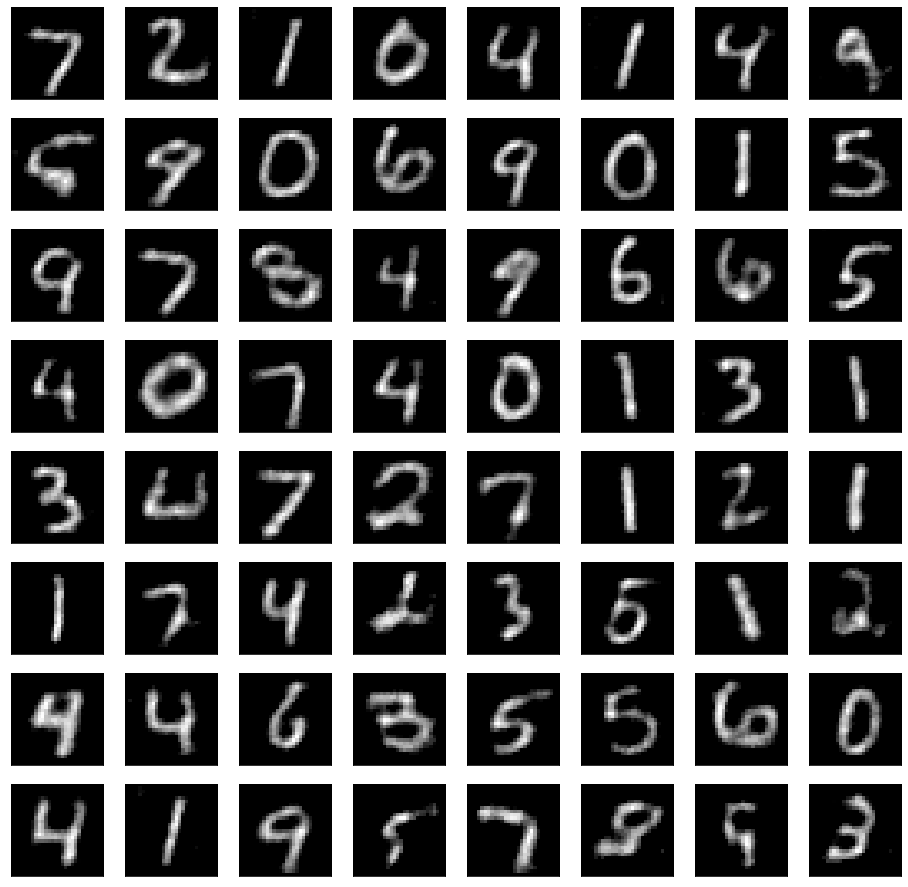

In [12]:
fig, axs = plt.subplots(8,8,figsize=(16,16))
for i in range(64):
  axs[i//8,i%8].imshow(o[i].cpu().detach().numpy().reshape(28,28),cmap="gray")
  axs[i//8,i%8].set_xticks([])
  axs[i//8,i%8].set_yticks([])

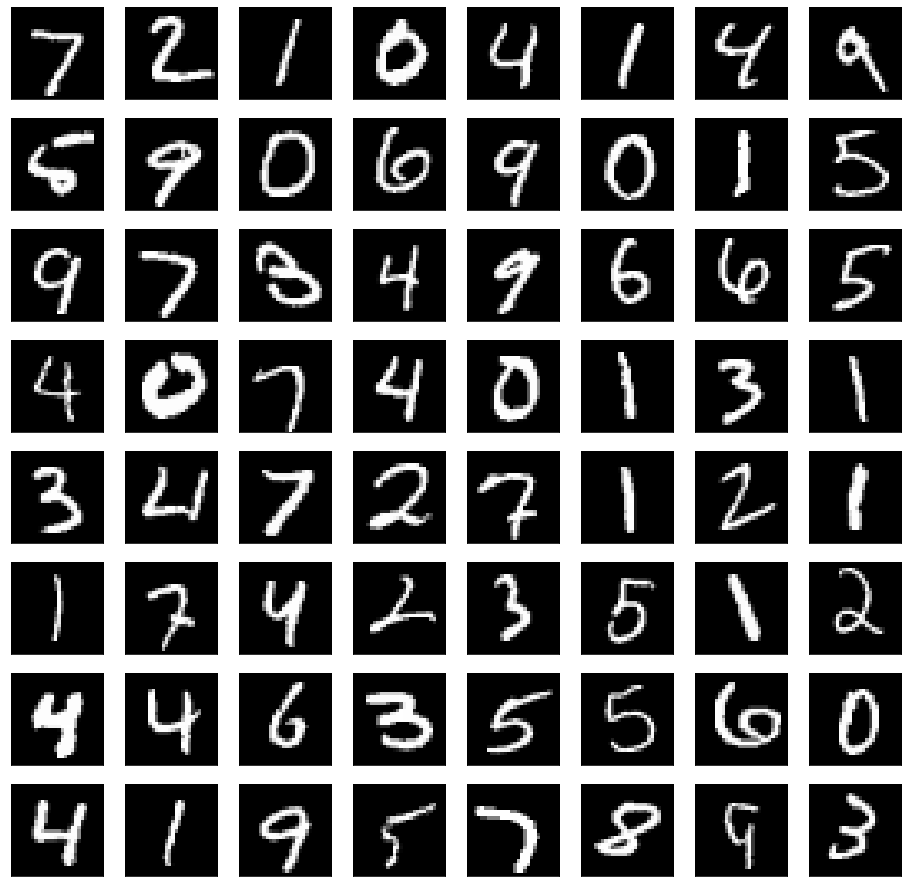

In [13]:
fig, axs = plt.subplots(8,8,figsize=(16,16))
for i in range(64):
  axs[i//8,i%8].imshow(x[i].cpu().detach().numpy().reshape(28,28),cmap="gray")
  axs[i//8,i%8].set_xticks([])
  axs[i//8,i%8].set_yticks([])


# GAN

In [20]:
generator = nn.Sequential(
    nn.Linear(100,7*7*32),
    Reshape((-1,32,7,7)),
    deconv_block(32,16),
    deconv_block(16,1)
).to(dev)

discriminator = nn.Sequential(
    conv_block(1,16),
    conv_block(16,32),
    conv_block(32,32),
    conv_block(32,64),
    nn.Flatten(),
    nn.Linear(64,1)
).to(dev)

In [21]:
crit = nn.BCEWithLogitsLoss()
optim_generator = torch.optim.SGD(generator.parameters(),lr=0.01)
optim_discriminator = torch.optim.SGD(discriminator.parameters(),lr=0.001)

In [26]:
generator.train()
discriminator.train()

for epoch in range(10):
  tot_loss_discriminator = 0
  tot_loss_generator = 0
  
  for x, _ in train_dl:
    x = x.to(dev)
    N, _, _,_ = x.shape
    noise = torch.randn((N,100)).to(dev)
    real_labels = torch.ones((N,1)).to(dev)
    fake_labels = torch.zeros((N,1)).to(dev)

    fake_imgs = generator(noise).detach()
    loss_discriminator = crit(discriminator(x),real_labels) + crit(discriminator(fake_imgs), fake_labels)
    tot_loss_discriminator += loss_discriminator.item()
    optim_discriminator.zero_grad()
    loss_discriminator.backward()
    optim_discriminator.step()

    noise = torch.randn((N,100)).to(dev)
    fake_imgs = generator(noise)
    loss_generator = crit(discriminator(fake_imgs), real_labels)
    tot_loss_generator += loss_generator.item()
    optim_generator.zero_grad()
    loss_generator.backward()
    optim_generator.step()
  print(f"loss discriminator:{tot_loss_discriminator/len(train_dl)}, loss generator: {tot_loss_generator/len(train_dl)}")

loss discriminator:0.18477644656361866, loss generator: 3.8330890464125824
loss discriminator:0.1845426701330967, loss generator: 3.8896014294835295
loss discriminator:0.16447627066430062, loss generator: 4.048453945857185
loss discriminator:0.17751596639874076, loss generator: 3.950104143144861
loss discriminator:0.15364629727130982, loss generator: 4.039781623339253
loss discriminator:0.15490523628346414, loss generator: 4.275403756402068
loss discriminator:0.15384694295270102, loss generator: 4.253903418060527
loss discriminator:0.15158007636384319, loss generator: 4.416843239972586
loss discriminator:0.12293417074644108, loss generator: 4.46968769866711
loss discriminator:0.11656962580897454, loss generator: 4.6249930471348675


In [27]:
generator.eval()
o = generator(torch.randn((16,100)).to(dev)).cpu()

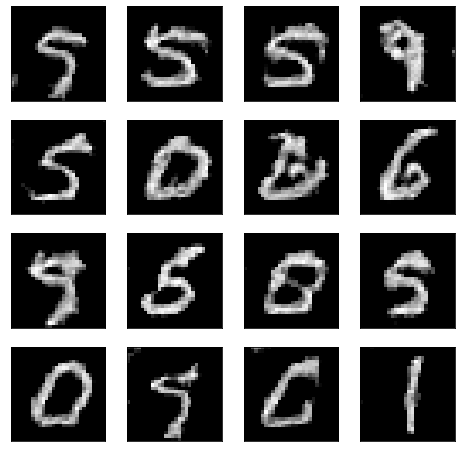

In [28]:
fig, axs = plt.subplots(4,4,figsize=(8,8))
for i in range(16):
  axs[i//4,i%4].imshow(o[i][0].detach().numpy(),cmap="gray")
  axs[i//4,i%4].set_xticks([])
  axs[i//4,i%4].set_yticks([]) 

In [29]:
torch.save(generator.state_dict(),"generator_mnist.ckpt")
torch.save(discriminator.state_dict(),"discriminator_mnist.ckpt")